In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',None)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize
import math
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv('data.csv')
df.shape

(71, 12)

In [3]:
df.sample(5)

,Dynol,Non ionic,Pushar,Hydrogel,Silica,CTAB,Surface Tension,Contact Angle,Average viscosity,area without finger,finger length,Effective area
60,0.0000,0.0,0.050,0.000000,0.10,0.0,28.90,19.3,0.0780,28.600000,6.480000,1.634720
23,0.0000,0.0,0.050,0.000000,0.00,0.0,29.09,16.0,0.0886,28.700000,5.900000,1.820764
17,0.0750,0.4,0.050,0.000000,0.00,0.2,28.97,13.5,0.0820,29.800000,6.233333,1.573312
25,0.0750,0.0,0.050,0.000000,0.00,0.2,29.50,17.2,0.0900,18.750000,5.893333,1.438757
58,0.0375,0.2,0.025,0.003125,0.05,0.0,26.50,19.2,0.0680,38.166667,13.633333,1.369518


In [4]:
features_input = np.array(['Dynol','Non ionic','Pushar','Hydrogel','Silica','CTAB'])
features_measured = np.array(['Surface Tension','Contact Angle','Average viscosity'])
features_output = np.array(['area without finger','finger length','Effective area'])

### Predicting Output features on the basis of fluid properties
#### Scatter plot (features vs output)

In [5]:
# for feature1 in features_input:
#     for feature2 in features_measured:
#         x = feature1
#         y = feature2
#         sns.regplot(data=df,x=x,y=y,ci=None,color='green',line_kws={'linewidth':1,'color':'blue'})
#         sns.despine()
#         plt.title(y+' vs '+x)
#         plt.show()

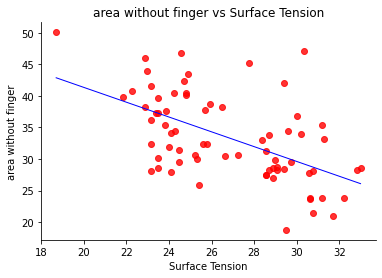

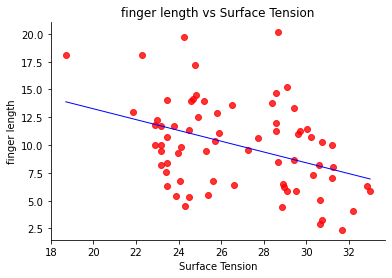

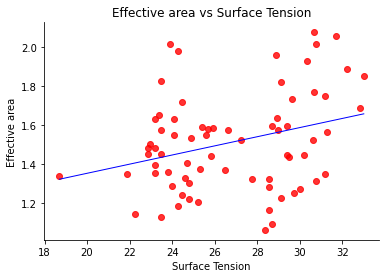

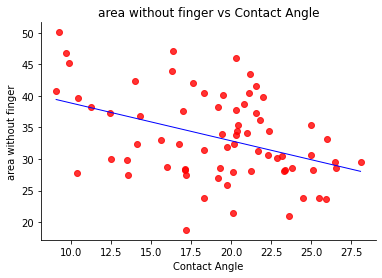

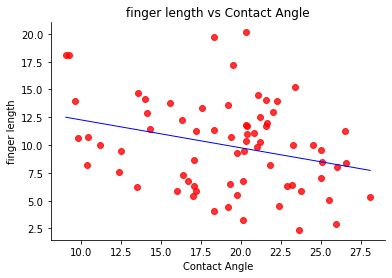

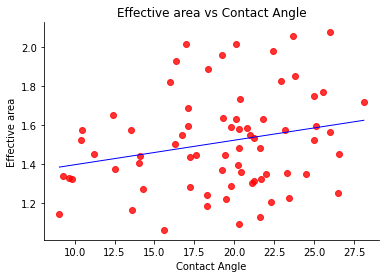

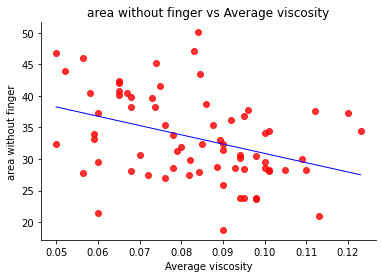

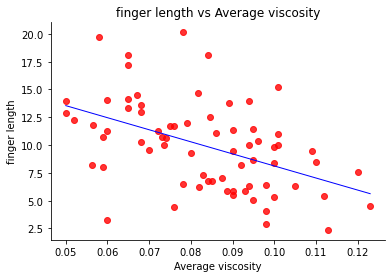

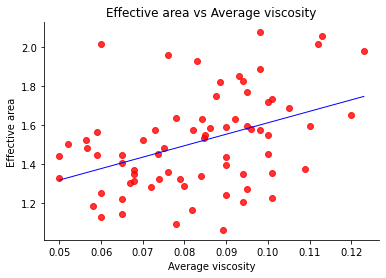

In [6]:
for feature1 in features_measured:
    for feature2 in features_output:
        x = feature1
        y = feature2
        sns.regplot(data=df,x=x,y=y,ci=None,color='red',line_kws={'linewidth':1,'color':'blue'})
        sns.despine()
        plt.title(y+' vs '+x)
        plt.show()

From above plots we can draw conclusions as -<br>
Surface tension, Contact angle, Average viscosity <b>inverse proportional</b> area without finger <br>
Surface tension, Contact angle, Average viscosity <b>inverse proportional</b> finger length <br>
Surface tension, Contact angle, Average viscosity <b>direct proportional</b> Effective area

but, points are scattered a lot, due to which building linear regression model to predict output is not going to be effective. 

In [7]:
# for feature1 in features_input:
#     for feature2 in features_output:
#         x = feature1
#         y = feature2
#         sns.regplot(data=df,x=x,y=y,ci=None,color='black',line_kws={'linewidth':1,'color':'blue'})
#         sns.despine()
#         plt.title(y+' vs '+x)
#         plt.show()

### Categorizing observations 

##### Calculating Effectiveness factor

Our aim is to maximize the "area without fingers" and minimize the "fingers length."<br>
To categorize observations into good and bad, here we combine these features into one called "Effectiveness factor" with the relation - <br>
##### $$ Effectivenessfactor=\frac{area\operatorname{with}outfinger}{finger\ \operatorname{length}^{x}} $$
x - <br>
here, we are assuming that both features have equal priority(which can be changed as per requirement), and to normalize the values, we are using<br> (finger length)^x at the place of finger length directly where - <br>
#### $$ x\ =\ \frac{\sum_{n=1}^{n}\frac{\log\left(area\ \operatorname{with}out\ fingers\right)}{\log\left(finger\ \operatorname{length}\right)}}{n} $$
where n = no. of observations

In [8]:
x1 = df['area without finger'].apply(lambda val: math.log(val))
x2 = df['finger length'].apply(lambda val: math.log(val))
xe = (x1/x2).mean()
xe

1.6511080191252654

In [9]:
EF = np.array([])

for index,value in df['Effective area'].items():
    if value>0:
        cal = df['area without finger'][index]/(df['finger length'][index]**xe)
        EF = np.append(EF,cal)
    else:
        print(index)
        EF = np.append(EF,np.nan)
EF = pd.DataFrame(EF)
EF.rename(columns={0:'EF'}, inplace=True)
df = pd.concat([df,EF],axis=1)
df.head()

,Dynol,Non ionic,Pushar,Hydrogel,Silica,CTAB,Surface Tension,Contact Angle,Average viscosity,area without finger,finger length,Effective area,EF
0,0.0750,0.4,0.000,0.006250,0.00,0.2,23.47,21.58,0.060,37.303333,14.046667,1.127079,0.475314
1,0.0375,0.2,0.025,0.003125,0.05,0.2,26.62,23.20,0.098,30.460000,6.400000,1.576359,1.421149
2,0.0375,0.2,0.025,0.003125,0.00,0.1,27.24,25.00,0.070,30.566667,9.533333,1.523732,0.738600
3,0.0000,0.0,0.000,0.006250,0.00,0.2,30.64,25.53,0.095,23.787000,5.100000,1.769078,1.614600
4,0.0000,0.0,0.050,0.000000,0.10,0.2,30.75,20.12,0.060,21.433000,3.277000,2.018137,3.019783


#### Classification

Here, we are taking the mean of the Effectiveness factor as a threshold. If the Effectiveness factor of observation is higher than the mean, it'll be a good observation, otherwise bad.

In [10]:
threshold = df['EF'].mean()
threshold

1.0597648421304222

In [11]:
target = (df['area without finger']/(df['finger length']**xe)) >= threshold
df = pd.concat([df,target],axis=1)
df.rename(columns={0:'target'}, inplace=True)
df.tail()

,Dynol,Non ionic,Pushar,Hydrogel,Silica,CTAB,Surface Tension,Contact Angle,Average viscosity,area without finger,finger length,Effective area,EF,target
66,0.0750,0.0,0.000,0.006250,0.10,0.0,24.10,21.00,0.100,34.166667,9.861667,1.548747,0.780698,False
67,0.0375,0.0,0.025,0.003125,0.05,0.1,25.20,22.30,0.094,30.583333,14.006667,1.208130,0.391527,False
68,0.0000,0.0,0.050,0.000000,0.00,0.2,30.64,25.96,0.098,23.700000,2.930000,2.076427,4.016978,True
69,0.0750,0.4,0.000,0.000000,0.00,0.0,22.26,9.05,0.065,40.766667,18.066667,1.143596,0.342818,False
70,0.0000,0.0,0.050,0.006250,0.00,0.0,32.84,17.10,0.105,28.233000,6.307000,1.689925,1.349470,True


#### Plotting target vs effective area

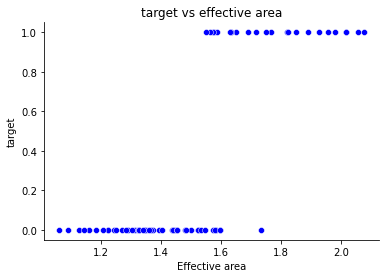

In [12]:
sns.scatterplot(y=df['target'],x=df['Effective area'],color='b')
plt.xlabel('Effective area')
plt.ylabel('target')
plt.title('target vs effective area')
sns.despine()
plt.show()

As per our target, "higher area without finger and lower finger length," the above plot also shows the same -<br>
For a higher effective area, observation is categorized as a good point, and for a lower effective area, a point is classified as a bad point, and on the<br> middling condition, finger length determines whether the point is good or bad.

## Predicting target on the basis of inputs

### Random Forest classification

In [13]:
X = df.loc[:,['Dynol','Non ionic','Pushar','Hydrogel','Silica','CTAB']]
Y = df['target']

#### Test train split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=50)

In [15]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
prediction = rf.predict(X_test)

#### Accuracy report

In [16]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
print("Confusin matrix: ")
print(confusion_matrix(y_test,prediction),'\n')
print("accuracy:",accuracy_score(y_test,prediction),'\n')
print("Classification report: ")
print(classification_report(y_test,prediction),'\n')

Confusin matrix: 
[[8 0]
 [4 3]] 

accuracy: 0.7333333333333333 

Classification report: 
              precision    recall  f1-score   support

       False       0.67      1.00      0.80         8
        True       1.00      0.43      0.60         7

    accuracy                           0.73        15
   macro avg       0.83      0.71      0.70        15
weighted avg       0.82      0.73      0.71        15
 



From the above classification, we are getting an accuracy of about <b>73%</b>, with the help of which we can predict, even before the experiment, whether the<br> output of our investigation will be useful or not. 

### Plotting measured features vs effectiveness factor

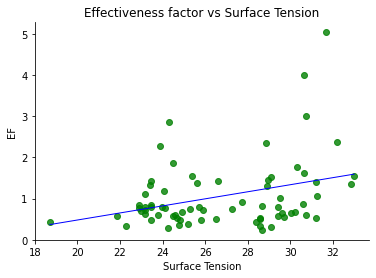

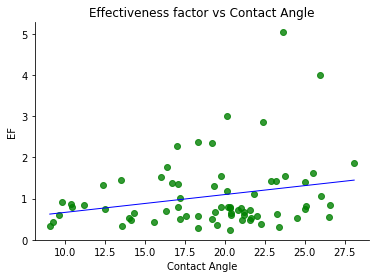

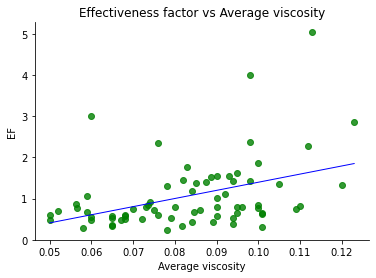

In [17]:
for feature1 in features_measured:
    x = feature1
    y = df['EF']
    sns.regplot(data=df,x=x,y=y,ci=None,color='g',line_kws={'linewidth':1,'color':'blue'})
    sns.despine()
    plt.title('Effectiveness factor vs '+x)
    plt.show()

The above plots show that points are significantly close to the regression line, which means we can use linear regression to predict whether the <br>observation will be good or bad with the help of fluid properties.

### Linear regression

In [18]:
lr = LinearRegression()

-------

### Clustering

In [19]:
import scipy.cluster.hierarchy as shc
# from sklearn.preprocessing import normalize

data = df.loc[:,['Effective area','area without finger']]
# data = normalize(data)
data

# plt.figure(figsize=(10, 7))
# # plt.title("Customer Dendograms")
# dend = shc.dendrogram(shc.linkage(df, method='ward'))

,Effective area,area without finger
0,1.127079,37.303333
1,1.576359,30.460000
2,1.523732,30.566667
3,1.769078,23.787000
4,2.018137,21.433000
...,...,...
66,1.548747,34.166667
67,1.208130,30.583333
68,2.076427,23.700000
69,1.143596,40.766667


In [20]:
from sklearn.cluster import AgglomerativeClustering

# data = np.array(data).reshape(1,142)
cluster = AgglomerativeClustering(n_clusters=2, metric='euclidean', linkage='ward')
labels_=cluster.fit_predict(data)
labels_


array([0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 1])

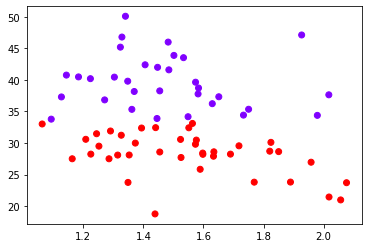

In [21]:
# plt.figure(figsize=(10, 7))
# print(data['Surface Tension'])
# print(data[:,1])
plt.scatter(data['Effective area'], data['area without finger'], c=cluster.labels_, cmap='rainbow')

In [22]:
from sklearn.metrics import silhouette_score

In [23]:

silhouette_score(data,labels_)

0.591732814670712

In [24]:
from sklearn.cluster import DBSCAN

In [25]:
dbscan = DBSCAN(eps=0.01,min_samples=6)
model = dbscan.fit(data)

In [26]:
labels = model.labels_

In [27]:
labels

array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1])

In [28]:
# silhouette_score(data,labels)

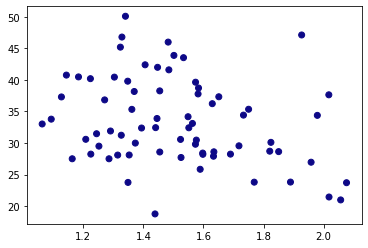

In [29]:
plt.scatter(data['Effective area'], data['area without finger'], c=labels, cmap='plasma')